# Base RAG Project
This is a simple implementation of Retrieval-Augmented Generation (RAG) using LangChain with ChromaDB. Tests will be conducted using Gemini models for generation and Ollama for embedding.

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

Now we set up langchain for google gemini models and ollama for embeddings.

In [2]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    "gemini-2.5-flash-lite", 
    model_provider="google_genai",
)

from langchain_ollama import OllamaEmbeddings

embeddings = OllamaEmbeddings(
    model="mxbai-embed-large:latest",
)

Now we init ChromaDB for storing and retrieving documents and vectors.

In [47]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="test_collection",
    embedding_function=embeddings,
    persist_directory="./chroma_db",
)


## Ingestion
Now we test ingesting a document.

In [48]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import TextLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

ONLY RUN THE FOLLOWING ONCE

In [ ]:
# Loading and splitting the document
loader = TextLoader(
    file_path="./texts/Alice's Adventures in Wonderland.txt",
    autodetect_encoding=True
    )

docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)

all_splits = text_splitter.split_documents(docs)

# Indexing the chunks into the vector store
_ = vector_store.add_documents(documents=all_splits)

In [7]:
prompt = ChatPromptTemplate(
    ["system", """You are a helpful assistant.
You will be given a question and a context.
Your task is to answer the question based on the context provided.
If the context does not contain enough information to answer the question, say "I don't know".
Question: {question}
Context: {context}
Answer:"""],
)

In [16]:
# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    
# Define application steps
def retrieve(state: State):
    """Retrieve relevant documents based on the question."""
    retrieved_docs = vector_store.similarity_search(
        state["question"]
        )

    return {"context": retrieved_docs}

def generate(state: State):
    """Generate an answer based on the question and context."""
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke(
        {
            "question": state["question"],
            "context": docs_content
        }
    )
    
    response = llm.invoke(messages)

    return {"answer": response.content}

## Build Graph

In [64]:
# Compile and test

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

NameError: name 'State' is not defined

In [18]:
response = graph.invoke({"question": "Summarise Chapter 1 of Alice's Adventures in Wonderland?"})
print(response["answer"])

Chapter 1, titled "Down the Rabbit-Hole," begins with Alice feeling bored and tired of sitting by her sister. She encounters a White Rabbit with pink eyes and decides to follow it. The rabbit disappears down a large rabbit-hole, and Alice, driven by curiosity, follows it. She falls down a long, deep well and eventually lands in a hall. Alice then finds a small golden key and unlocks a door that leads to a beautiful garden.


## Making it a conversation instead of a single question
Now we try to make it conversible

In [75]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

See this guide on how to make tools 
https://python.langchain.com/docs/how_to/custom_tools/

In [76]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    print(f"Retrieved {retrieved_docs}")
    return serialized, retrieved_docs

## LangGraph RAG
Now we redo the graph to accomodate a tool workflow

In [77]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. You can use your tools as many times as you want and need to complete the task."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [78]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

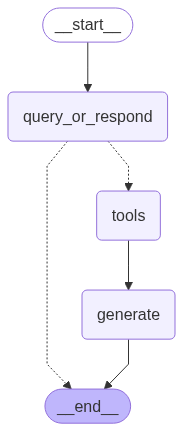

In [79]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [57]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [36]:
input_message = "What is a loopagent?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is a loopagent?
================================== Ai Message ==================================
Tool Calls:
  retrieve (ce4d3553-3fbc-441d-b40f-e2245ba203f5)
 Call ID: ce4d3553-3fbc-441d-b40f-e2245ba203f5
  Args:
    query: loopagent
Retrieved []
================================= Tool Message =================================
Name: retrieve


================================== Ai Message ==================================

A loopagent is a type of artificial intelligence that can perform tasks in a continuous cycle or "loop." These agents are designed to repeatedly execute a set of actions until a specific condition is met or indefinitely. They are often used in simulations, process automation, and game development.


# State Management of LangGraph

In [80]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [71]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?
================================== Ai Message ==================================
Tool Calls:
  retrieve (d5f67878-3daa-479d-b5c0-a5dc86ce1523)
 Call ID: d5f67878-3daa-479d-b5c0-a5dc86ce1523
  Args:
    query: Task Decomposition
Retrieved [Document(id='e720cbb1-c11f-4c59-a59e-a93c4e5f9b89', metadata={'source': './texts/cloud-design-patterns.txt'}, page_content='Intent .................................................................................................................................................... 49\n    Motivation ............................................................................................................................................ 49\n    Applicability .......................................................................................................................................... 49\n    Issues and considerations ................

## Note
This following code if re run will use the same thread memory. So it can reference prior message context.

In [39]:
input_message = "What have we talked about?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What have we talked about?
================================== Ai Message ==================================

We have discussed Task Decomposition. I explained that it's the process of breaking down large, complex tasks into smaller, more manageable subtasks to simplify the overall objective, making it easier to plan, execute, and monitor progress.


# Attempting Agentic Version

In [81]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

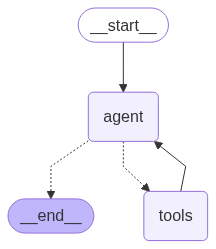

In [82]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [83]:
config = {"configurable": {"thread_id": "def12"}}

input_message = (
    "List all the cloud design patterns\n\n"
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

List all the cloud design patterns


================================== Ai Message ==================================
Tool Calls:
  retrieve (8832a703-aaa8-4406-b5be-f82925b511a0)
 Call ID: 8832a703-aaa8-4406-b5be-f82925b511a0
  Args:
    query: cloud design patterns
Retrieved [Document(id='d5defab3-ec03-44d6-8636-40c25e379c56', metadata={'source': './texts/cloud-design-patterns.txt'}, page_content='This guide provides a technical reference for cloud architects, technical leads, application and business owners, and developers who want to choose the right cloud architecture for design patterns based on well-architected best practices. Each pattern discussed in this guide addresses one or more known scenarios in microservices architectures. The guide discusses the issues and considerations associated with each pattern, provides a high-level architectural implementation, and describes the AWS implementation 

# DO NOT RUN 
## This is for testing use code only
Code to find and delete items

In [ ]:
items = vector_store.get(where={"source": "./texts/Alive's Adventures in Wonderland.txt"})  # Get all ids in the vector store
vector_store.delete(ids=items.get("ids", []))  # Delete the items from the vector store

items = vector_store.get(where={"source": "./texts/Alice's Adventures in Wonderland.txt"})  # Get all ids in the vector store
print(f"Number of existing docs: {len(items.get('ids', []))}")